The u (vozocrtx) and v (vomecrty) velocitys are given in the ij-coordinate system, that is, along the lines connecting the f-points. If this is true, and oceanparcels handle thi   s correctly, if v and w are set to 0, any tracing should be tilted to the north-east axis. Here I've set the V and W velocities to 0. Caveat: maybe oceanparcels check the divergence and do some "magic"

In [1]:
import datetime
import pathlib

from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4_3D
import parcels
import xarray

from parcels import logger, XarrayDecodedFilter
logger.addFilter(XarrayDecodedFilter())  # Add a filter for the xarray decoding warning

# Subset, lower left corner of my grid
enatl_data_path = pathlib.Path('day_1_5')
zero_vw_data_path = pathlib.Path('enatl60_vw_zero')
u_files = sorted(enatl_data_path.glob('*1d_vozocrtx*'))
v_files = sorted(zero_vw_data_path.glob('*1d_vomecrty*'))
w_files = sorted(zero_vw_data_path.glob('*1d_vovecrtz*'))

assert len(u_files) == len(w_files)
assert len(u_files) == len(v_files)

enatl_mesh_mask_file = enatl_data_path / 'mesh_mask_eNATL60FARSHE_3.6.nc'

In [2]:
filenames = {
    'U': {'lon': enatl_mesh_mask_file, 'lat': enatl_mesh_mask_file, 'depth': w_files[0], 'data': u_files},
    'V': {'lon': enatl_mesh_mask_file, 'lat': enatl_mesh_mask_file, 'depth': w_files[0], 'data': v_files},
    'W': {'lon': enatl_mesh_mask_file, 'lat': enatl_mesh_mask_file, 'depth': w_files[0], 'data': w_files},
}

variables = {
    'U': 'vozocrtx',
    'V': 'vomecrty',
    'W': 'vovecrtz',
}

dimensions = {
    'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
    'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
    'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
}

In [3]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

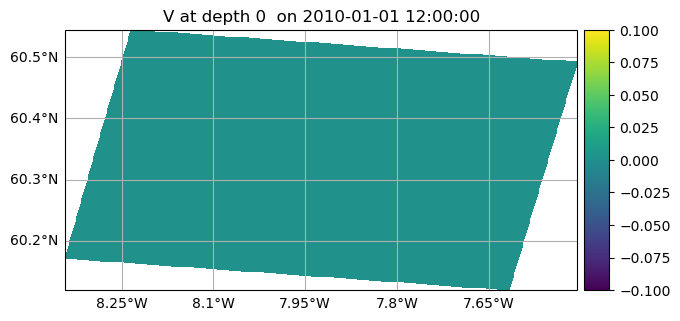

In [4]:
fieldset.V.show()

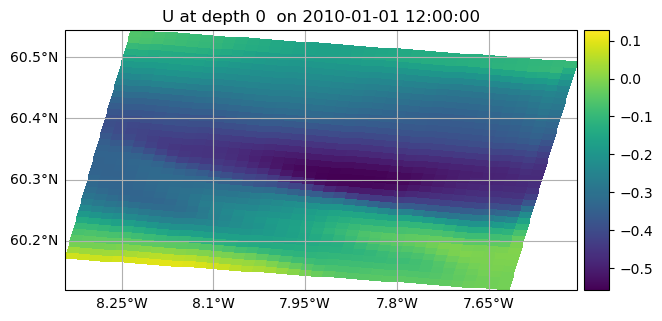

In [5]:
fieldset.U.show()

In [6]:
start_point = (-7.883789, 60.239120)  # y_c = 9, x_r = 21
stop_point = (-7.857898, 60.327419)  # y_c = 18, x_r = 21
depth = 52.48403405  # z_c = 20

pset = ParticleSet.from_line(
    fieldset=fieldset,
    pclass=JITParticle,
    size=10,
    start=start_point,
    finish=stop_point,
    depth=depth,
)
kernels = pset.Kernel(AdvectionRK4_3D)

In [7]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [8]:

output_file = pset.ParticleFile(name='output_vw_zero.zarr', outputdt=datetime.timedelta(hours=6))
starttime = datetime.datetime(2010, 1, 1, 12)
endtime = starttime + datetime.timedelta(days=4)
runtime = endtime - starttime

pset.execute(kernels, runtime=runtime, dt=datetime.timedelta(hours=6), output_file=output_file, recovery={parcels.ErrorCode.ErrorOutOfBounds: DeleteParticle},)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /var/folders/kk/m6gqzmx50nxfthwxklx9dr640000gp/T/parcels-502/lib16d8c1a10611ccae88a22da8be91c6a4_0.so


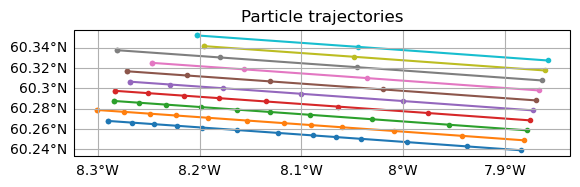

<module 'matplotlib.pyplot' from '/Users/niten/.local/anaconda/envs/opt-m1-lagrangian/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [9]:
parcels.plotTrajectoriesFile('output_vw_zero.zarr')

# Finally, this is good